## Imports

In [22]:
%matplotlib inline

import venn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import networkx as nx
import glob as glob

pio.templates.default = 'plotly_white'
pd.options.mode.chained_assignment = None

## Load in adjacency matrices and turn them into networkx graphs

In [2]:
def load_edge_mat(fn):
    mat = pd.read_csv(fn, sep=",", index_col=0)
    return mat

network_fn = glob.glob("*.csv")

mats = dict()
g_list = dict()

for f in network_fn:
    name = f.split(".")[0]
    mat = load_edge_mat(f)
    mats[name] = mat
    
    g = nx.from_pandas_adjacency(mat, nx.DiGraph)
    g_list[name] = g

In [3]:
mats.keys()

dict_keys(['sCerevisiae', 'gMetallireducens', 'kPneumoniae', 'bSubtilis', 'eColi'])

In [28]:
mats['eColi']

,2AGPEAT120,APH120,FA120ACPHi,FACOAE120,LPLIPAL2A120,LPLIPAL2E120,LPLIPAL2G120,2AGPGAT120,AACPS7,ACPPAT120,...,POAACR,3KGK,ASCBPL,LYXI,GOFUCR,2DGULRx,2DGULRy,3AMACHYD,DOGULNR,MSAR
2AGPEAT120,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
APH120,1,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
FA120ACPHi,1,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
FACOAE120,1,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
LPLIPAL2A120,1,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2DGULRx,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2DGULRy,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3AMACHYD,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
DOGULNR,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


## In degree overlap

In [146]:
# compute in and out degrees for each organism and rank
ins = dict()
for name in mats.keys():
    ins[name] = mats[name].sum(axis = 0).sort_values(ascending=False)[0:50]

In [151]:
# intersect of top 50 reactions with highest in degree
# input these reactions into BIGG to get KEGG reaction name
# then input KEGG reactions into KEGG pathway mapper
common_top_in = (ins['gMetallireducens'].index).intersection(ins['eColi'].index).intersection(ins['kPneumoniae'].index).intersection(ins['bSubtilis'].index)
print(common_top_in)

Index(['AKGDH', 'SUCOAS', 'ACGS', 'PDH', 'ALATA_L', 'SERAT', 'ACS', 'ACACT1r',
       'PTAr'],
      dtype='object')


/Users/mtsui1/opt/anaconda3/envs/gen/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


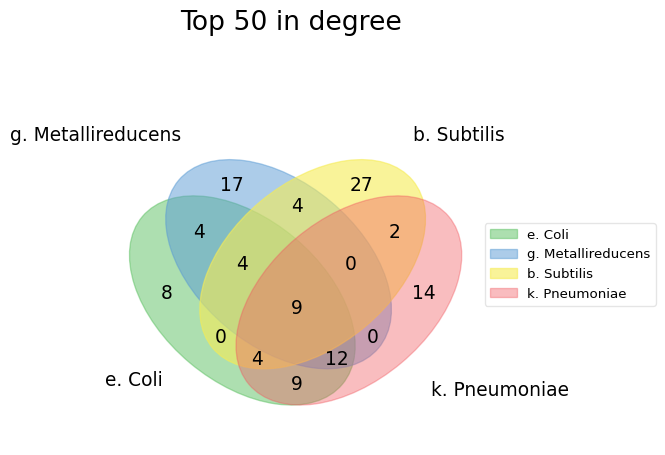

In [148]:
# Venn diagram
labels = venn.get_labels([ins['eColi'].index, ins['gMetallireducens'].index, ins['bSubtilis'].index, ins['kPneumoniae'].index], fill=['number', 'logic'])
vals = [i.split(": ",1)[1] for i in list(labels.values())]
labs = dict(zip(list(labels.keys()), vals))

fig, ax = venn.venn4(labs, names=['e. Coli', 'g. Metallireducens', 'b. Subtilis', 'k. Pneumoniae'], figsize=(5,5))
fig.suptitle('Top 50 in degree', size=20, va='bottom')
fig.show()
#fig.savefig('./cascade_venn.pdf', bbox_inches='tight')

## Cascade number overlap

In [53]:
class CascadeNumber:
    
    def __init__(self, dg):
        self.dg = dg
        self.rg = nx.reverse_view(dg)
        self.knockouts = set()
        self.cn = 0
    
    def calculate(self, n, first=True, verbose=False):
        if verbose:
            print("checking node : {}".format(n))


        # first recursion
        if first:
            self.knockouts = set()
            self.cn = 0
            
            self.knockouts.add(n)
            for n in self.dg.neighbors(n):
                self.calculate(n, first=False)
            return self.cn
        
        # every other recursion
        else:
            # stops self loops
            if n in self.knockouts:
                return
        
            parent_nodes = set(self.rg.neighbors(n))
            
            # all parent nodes have been knocked out
            if (parent_nodes.intersection(self.knockouts) == parent_nodes):
                self.cn += 1
                self.knockouts.add(n)
                for child in self.dg.neighbors(n):
                    self.calculate(child, first=False)
                    
            # not all parent nodes have been knocked out
            else:
                return
        
cascade = dict()
for name in mats.keys():
    cn = CascadeNumber(g_list[name])
    df = pd.DataFrame(
            np.array([[n, cn.calculate(n)] for n in g_list[name].nodes()]), 
            columns = ['Node', "CascadeNumber"]
        )
    df['CascadeNumber'] = df['CascadeNumber'].apply(pd.to_numeric)
    cascade[name] = df.sort_values(by="CascadeNumber", ascending=False,ignore_index=True).loc[0:49,]

In [149]:
cascade['eColi'].head()

,Node,CascadeNumber
0,GTPCI,7
1,GLUTRS,7
2,ASAD,7
3,MECDPDH5,7
4,XAND,6


In [150]:
# intersection of top 50 highest cascade number
# input these reactions into BIGG to get KEGG reaction name
# then input KEGG reactions into KEGG pathway mapper
common_top_casc = np.intersect1d(np.intersect1d(cascade['gMetallireducens']['Node'], cascade['bSubtilis']['Node']), np.intersect1d(cascade['eColi']['Node'], cascade['kPneumoniae']['Node']))
print(common_top_casc)

['G1SAT' 'GLUTRR' 'GLUTRS' 'PPBNGS']


/Users/mtsui1/opt/anaconda3/envs/gen/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys


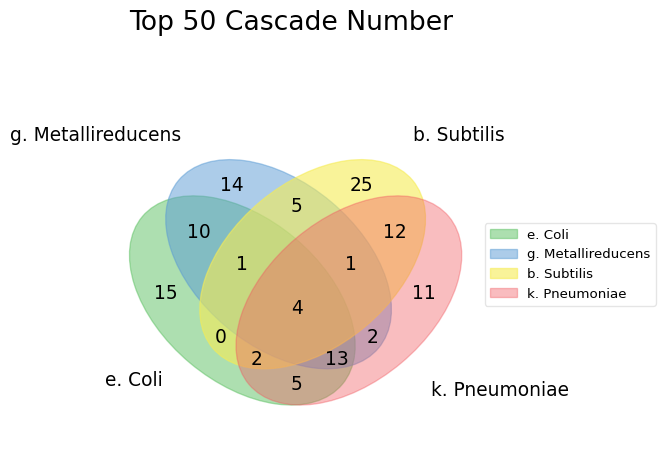

In [13]:
# Venn diagram
labels = venn.get_labels([cascade['eColi']['Node'], cascade['gMetallireducens']['Node'], cascade['bSubtilis']['Node'], cascade['kPneumoniae']['Node']], fill=['number', 'logic'])
vals = [i.split(": ",1)[1] for i in list(labels.values())]
labs = dict(zip(list(labels.keys()), vals))

fig, ax = venn.venn4(labs, names=['e. Coli', 'g. Metallireducens', 'b. Subtilis', 'k. Pneumoniae'], figsize=(5,5))
fig.suptitle('Top 50 Cascade Number', size=20, va='bottom')
fig.show()
fig.savefig('./cascade_venn.pdf', bbox_inches='tight')

## Correlations

In [139]:
# Which two species have the highest overlap betw top50 in degree reactions? eColi and kPneumoniae
for species1 in ins.keys():
    for species2 in ins.keys():
        overlap = len((ins[species1].index).intersection(ins[species2].index))
        print(species1 + " and " + species2 + ": " + str(overlap))

sCerevisiae and sCerevisiae: 50
sCerevisiae and gMetallireducens: 4
sCerevisiae and kPneumoniae: 3
sCerevisiae and bSubtilis: 6
sCerevisiae and eColi: 3
gMetallireducens and sCerevisiae: 4
gMetallireducens and gMetallireducens: 50
gMetallireducens and kPneumoniae: 21
gMetallireducens and bSubtilis: 17
gMetallireducens and eColi: 29
kPneumoniae and sCerevisiae: 3
kPneumoniae and gMetallireducens: 21
kPneumoniae and kPneumoniae: 50
kPneumoniae and bSubtilis: 15
kPneumoniae and eColi: 34
bSubtilis and sCerevisiae: 6
bSubtilis and gMetallireducens: 17
bSubtilis and kPneumoniae: 15
bSubtilis and bSubtilis: 50
bSubtilis and eColi: 17
eColi and sCerevisiae: 3
eColi and gMetallireducens: 29
eColi and kPneumoniae: 34
eColi and bSubtilis: 17
eColi and eColi: 50


/Users/mtsui1/opt/anaconda3/envs/gen/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys
/Users/mtsui1/opt/anaconda3/envs/gen/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


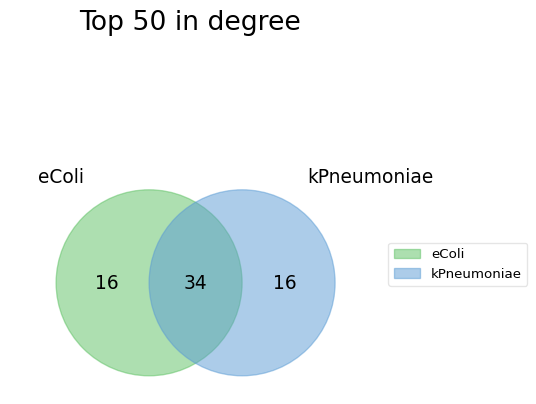

In [143]:
labels = venn.get_labels([ins['eColi'].index, ins['kPneumoniae'].index], fill=['number', 'logic'])
vals = [i.split(": ",1)[1] for i in list(labels.values())]
labs = dict(zip(list(labels.keys()), vals))

fig, ax = venn.venn2(labs, names=['eColi', 'kPneumoniae'], figsize=(5,5))
fig.suptitle('Top 50 in degree', size=20, va='bottom')
fig.show()
fig.show()

0.9597558807899532


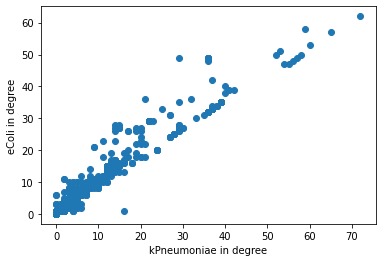

In [127]:
# corr betw KP and EC in degree (shared reactions)
KP_ins = mats['kPneumoniae'].sum(axis = 1)
EC_ins = mats['eColi'].sum(axis = 1)
overlap = (KP_ins.index).intersection(EC_ins.index)

corr = pd.Series.corr(KP_ins[overlap], EC_ins[overlap], method="spearman")
print(corr)
plt.scatter(KP_ins[overlap].values, EC_ins[overlap].values, marker='o')
plt.xlabel("kPneumoniae in degree")
plt.ylabel("eColi in degree");

0.881264880345736


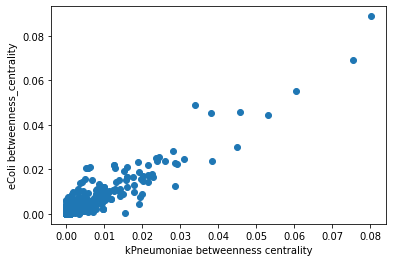

In [124]:
# corr betw KP and EC betw centrality (shared reactions)
KP_bc = pd.Series(nx.betweenness_centrality(g_list['kPneumoniae']))
EC_bc = pd.Series(nx.betweenness_centrality(g_list['eColi']))
overlap = (KP_bc.index).intersection(EC_bc.index)
corr = pd.Series.corr(KP_bc[overlap], EC_bc[overlap], method="spearman")
print(corr)

plt.scatter(KP_bc[overlap].values, EC_bc[overlap].values, marker='o')
plt.xlabel("kPneumoniae betweenness centrality")
plt.ylabel("eColi betweenness_centrality");

0.9184910939289493


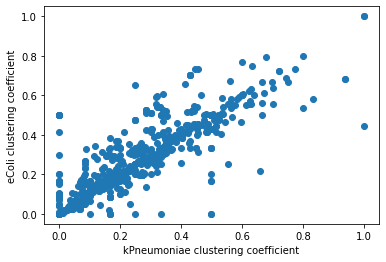

In [125]:
# corr betw KP and EC clustering coeff (shared reactions)
KP_cc = pd.Series(nx.clustering(g_list['kPneumoniae']))
EC_cc = pd.Series(nx.clustering(g_list['eColi']))
overlap = (KP_cc.index).intersection(EC_cc.index)
corr = pd.Series.corr(KP_cc[overlap], EC_cc[overlap], method="spearman")
print(corr)
plt.scatter(KP_cc[overlap].values, EC_cc[overlap].values, marker='o')
plt.xlabel("kPneumoniae clustering coefficient")
plt.ylabel("eColi clustering coefficient");


0.8202569197835176


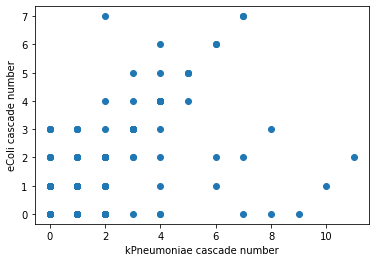

In [126]:
# corr betw KP and EC cascade (shared reactions)
overlap = list((KP_ins.index).intersection(EC_ins.index))

cn = CascadeNumber(g_list['kPneumoniae'])
KP_cn = pd.DataFrame(
        np.array([[n, cn.calculate(n)] for n in g_list['kPneumoniae'].nodes()]), 
        columns = ['Node', "CascadeNumber"]
    )
KP_cn['CascadeNumber'] = KP_cn['CascadeNumber'].apply(pd.to_numeric)
KP_cn.set_index(keys = 'Node', inplace=True)

cn = CascadeNumber(g_list['eColi'])
EC_cn = pd.DataFrame(
        np.array([[n, cn.calculate(n)] for n in g_list['eColi'].nodes()]), 
        columns = ['Node', "CascadeNumber"]
    )
EC_cn['CascadeNumber'] = EC_cn['CascadeNumber'].apply(pd.to_numeric)
EC_cn.set_index(keys = 'Node', inplace=True)

corr = pd.Series.corr(KP_cn.CascadeNumber[overlap], EC_cn.CascadeNumber[overlap], method="spearman")
print(corr)
plt.scatter(KP_cn.CascadeNumber[overlap], EC_cn.CascadeNumber[overlap], marker='o')
plt.xlabel("kPneumoniae cascade number")
plt.ylabel("eColi cascade number");

In [99]:
# Which two species have the highest overlap betw top50 in cascade? eColi and gMetallireducens
for species1 in ins.keys():
    for species2 in ins.keys():
        overlap = len(np.intersect1d(cascade[species1]['Node'], cascade[species2]['Node']))
        print(species1 + " and " + species2 + ": " + str(overlap))



sCerevisiae and sCerevisiae: 50
sCerevisiae and gMetallireducens: 9
sCerevisiae and kPneumoniae: 8
sCerevisiae and bSubtilis: 13
sCerevisiae and eColi: 7
gMetallireducens and sCerevisiae: 9
gMetallireducens and gMetallireducens: 50
gMetallireducens and kPneumoniae: 20
gMetallireducens and bSubtilis: 11
gMetallireducens and eColi: 28
kPneumoniae and sCerevisiae: 8
kPneumoniae and gMetallireducens: 20
kPneumoniae and kPneumoniae: 50
kPneumoniae and bSubtilis: 19
kPneumoniae and eColi: 24
bSubtilis and sCerevisiae: 13
bSubtilis and gMetallireducens: 11
bSubtilis and kPneumoniae: 19
bSubtilis and bSubtilis: 50
bSubtilis and eColi: 7
eColi and sCerevisiae: 7
eColi and gMetallireducens: 28
eColi and kPneumoniae: 24
eColi and bSubtilis: 7
eColi and eColi: 50


/Users/mtsui1/opt/anaconda3/envs/gen/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


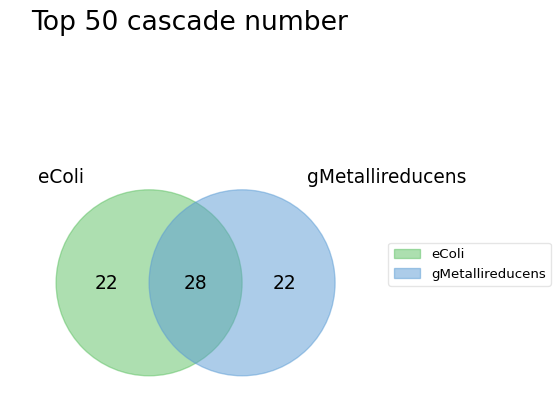

In [144]:
labels = venn.get_labels([cascade['eColi']['Node'], cascade['gMetallireducens']['Node']], fill=['number', 'logic'])
vals = [i.split(": ",1)[1] for i in list(labels.values())]
labs = dict(zip(list(labels.keys()), vals))

fig, ax = venn.venn2(labs, names=['eColi', 'gMetallireducens'], figsize=(5,5))
fig.suptitle('Top 50 cascade number', size=20, va='bottom')

fig.show()

0.8723174205975592


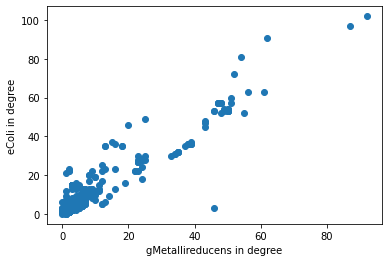

In [128]:
# corr betw EC and GM in degree (shared reactions)
GM_ins = mats['gMetallireducens'].sum(axis = 0)
EC_ins = mats['eColi'].sum(axis = 0)
overlap = (GM_ins.index).intersection(EC_ins.index)

corr = pd.Series.corr(GM_ins[overlap], EC_ins[overlap], method="spearman")
print(corr)
plt.scatter(GM_ins[overlap].values, EC_ins[overlap].values, marker='o')
plt.xlabel("gMetallireducens in degree")
plt.ylabel("eColi in degree");

0.8187735481461289


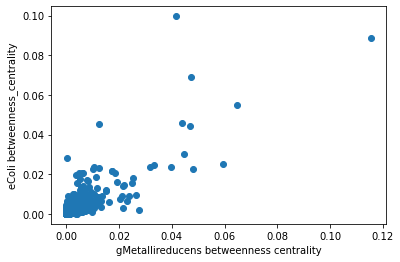

In [130]:
# corr betw EC and BS betw centrality (shared reactions)
GM_bc = pd.Series(nx.betweenness_centrality(g_list['gMetallireducens']))
EC_bc= pd.Series(nx.betweenness_centrality(g_list['eColi']))
overlap = (GM_bc.index).intersection(EC_bc.index)
corr = pd.Series.corr(GM_bc[overlap], EC_bc[overlap], method="spearman")
print(corr)
plt.scatter(GM_bc[overlap].values, EC_bc[overlap].values, marker='o')
plt.xlabel("gMetallireducens betweenness centrality")
plt.ylabel("eColi betweenness_centrality");


0.8412304483594173


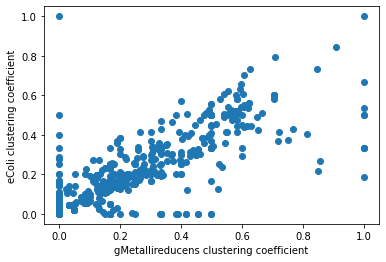

In [131]:
# corr betw EC and BS clustering coeff (shared reactions)
GM_cc = pd.Series(nx.clustering(g_list['gMetallireducens']))
EC_cc = pd.Series(nx.clustering(g_list['eColi']))
overlap = (GM_cc.index).intersection(EC_cc.index)
corr = pd.Series.corr(GM_cc[overlap], EC_cc[overlap], method="spearman")
print(corr)
plt.scatter(GM_cc[overlap].values, EC_cc[overlap].values, marker='o')
plt.xlabel("gMetallireducens clustering coefficient")
plt.ylabel("eColi clustering coefficient");


0.7396379395007874


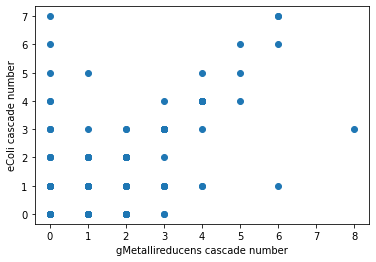

In [132]:
# corr betw EC and BS cascade (shared reactions)
cn = CascadeNumber(g_list['gMetallireducens'])
GM_cn = pd.DataFrame(
        np.array([[n, cn.calculate(n)] for n in g_list['gMetallireducens'].nodes()]), 
        columns = ['Node', "CascadeNumber"]
    )
GM_cn['CascadeNumber'] = GM_cn['CascadeNumber'].apply(pd.to_numeric)
GM_cn.set_index(keys = 'Node', inplace=True)

cn = CascadeNumber(g_list['eColi'])
EC_cn = pd.DataFrame(
        np.array([[n, cn.calculate(n)] for n in g_list['eColi'].nodes()]), 
        columns = ['Node', "CascadeNumber"]
    )
EC_cn['CascadeNumber'] = EC_cn['CascadeNumber'].apply(pd.to_numeric)
EC_cn.set_index(keys = 'Node', inplace=True)

corr = pd.Series.corr(GM_cn.CascadeNumber[overlap], EC_cn.CascadeNumber[overlap], method="spearman")
print(corr)
plt.scatter(GM_cn.CascadeNumber[overlap], EC_cn.CascadeNumber[overlap], marker='o')
plt.xlabel("gMetallireducens cascade number")
plt.ylabel("eColi cascade number");